<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Creating a simple 2D scarp diffusion model with Landlab

Import the Numpy library, which we'll use for some array calculations

In [1]:
import numpy

We will create a grid for our model using Landlab's *RasterModelGrid* class, which we need to import.

In [2]:
from landlab import RasterModelGrid

The syntax in the next line says: create a new *RasterModelGrid* object called **mg**, with 25 rows, 40 columns, and a grid spacing of 10 m.

In [3]:
mg = RasterModelGrid(25, 40, 10.0)

Now we'll add a *data field* to the grid, to represent the elevation values at grid nodes. The "dot" syntax indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field `land_surface__elevation`. The `add_zeros` method returns the newly created Numpy array.

In [4]:
z = mg.add_zeros('node', 'land_surface__elevation')

Let's take a look at the grid we've created. To do so, we'll use the Pylab graphics library (imported under the name `plt`). We also have to tell the iPython Notebook to display plots right here on the page.

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import pylab as plt

Let's plot the positions of all the grid nodes. The nodes' *(x,y)* positions are stored in the arrays `mg.node_x` and `mg.node_y`, respectively.

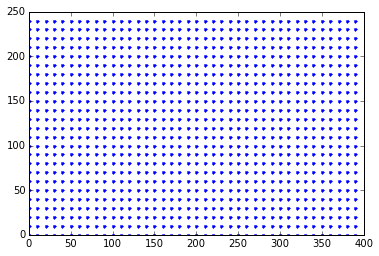

In [7]:
plt.plot(mg.node_x, mg.node_y, '.')

If we bothered to count, we'd see that there are 1000 grid nodes (25 x 40). The `z` array also has 1000 entries: one per grid cell.

In [8]:
len(z)

1000

Now for some tectonics. Let's say there's a fault trace that angles roughly east-northeast. We can describe the trace with the equation for a line. One trick here: by using `mg.node_x`, we are calculating a *y* (i.e., north-south) position of the fault trace for each grid node---meaning that this is the *y* coordinate of the trace at the *x* coordinate of a given node.

In [9]:
fault_trace_y = 50.0 + 0.25*mg.node_x

We find the ID numbers of the nodes north of the fault trace with help from Numpy's `where()` function.

In [10]:
upthrown_nodes = numpy.where(mg.node_y > fault_trace_y)

Here comes the earthquake. For all the nodes that we identified as being north of the fault, we'll add elevation equal to 10 meters plus a centimeter for every meter east along the grid (just to make it interesting).

In [11]:
z[upthrown_nodes] += 10.0 + 0.01*mg.node_x[upthrown_nodes]

Let's look at our newly created initial topography using Landlab's *imshow_node_grid* plotting function (which we first need to import).

In [12]:
from landlab.plot.imshow import imshow_node_grid

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


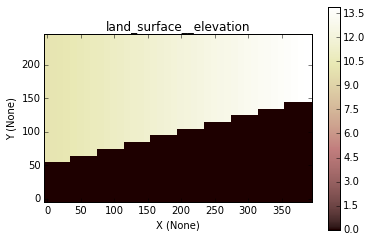

In [13]:
imshow_node_grid(mg, 'land_surface__elevation')

To finish getting set up, we will define two parameters: the transport ("diffusivity") coefficient, `D`, and the time-step size, `dt`. (The latter is set using the Courant condition for a forward-time, centered-space finite-difference solution.)

In [14]:
D = 0.01  # m2/yr transport coefficient

In [15]:
dt = 0.2*mg.dx*mg.dx/D

In [16]:
dt

2000.0

Boundary conditions: for this example, we'll assume that the east and west sides are closed to flow of sediment, but that the north and south sides are open.

In [17]:
mg.set_closed_boundaries_at_grid_edges(False, True, False, True)

In a moment we will calculate changes in elevation for the inner or **core** nodes---those that are not boundaries---and so we'll need to remember their ID numbers.

In [18]:
core_nodes = mg.core_nodes

In [19]:
len(core_nodes)

874

And now for some landform evolution. We will loop through 25 iterations, representing 50,000 years. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the gradient between each neighboring pair of nodes. These calculations are done on **active links**.

2. Calculate, and store in the array `qs`, the sediment flux between each adjacent pair of nodes by multiplying their gradient by the transport coefficient.

3. Calculate, and store in `dqsdx`, the resulting net flux at each node (positive=net outflux, negative=net influx).

4. The rate of change of node elevation, `dzdt`, is simply `-dqsdx`.

5. Update the elevations for the new time step.

In [20]:
for i in range(25):
    g = mg.calculate_gradients_at_active_links(z)
    qs = -D*g
    dqsdx = mg.calculate_flux_divergence_at_nodes(qs)
    dzdt = -dqsdx
    z[core_nodes] += dzdt[core_nodes]*dt

Let's look at how our fault scarp has evolved.

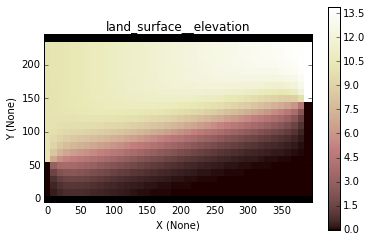

In [21]:
imshow_node_grid(mg, 'land_surface__elevation')

Notice that we have just created and run a 2D model of fault-scarp creation and diffusion with fewer than two dozen lines of code. How long would this have taken to write in C or Fortran?

Complete code can be found here: https://github.com/landlab/tutorials/blob/master/fault_scarp/landlab-fault-scarp.py

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>